In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchmetrics.regression import MeanAbsolutePercentageError
import sklearn.preprocessing

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot


C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
#Load data
df = pd.read_csv("cgm_data.csv").sample(frac=1) #shuffle data rows (patients)
for column in df.columns:
    df[column] = df[column].astype(float) #convert columns into floats
ptids = df["ptid"]
df = df.drop("ptid",axis=1)
df = df.iloc[:96,:] # keep only 96 patients

In [3]:
train_df = df.iloc[:90,:]
test_df = df.iloc[90:,:]

# Intro

We will be using ARIMA as a baseline to compare to our deeplearning models. In order to use ARIMA effectively we need to figure out the p,d,q parameters

p: The number of lag observations included

d: The number of times that observations are differenced

q: The size of the average window.


## Finding P

In order to find p we will take the mean across each patient for each time point and then make a partial autocorrleation plot using that waveform

In [113]:
mean_df = train_df.mean()
std = train_df.std()

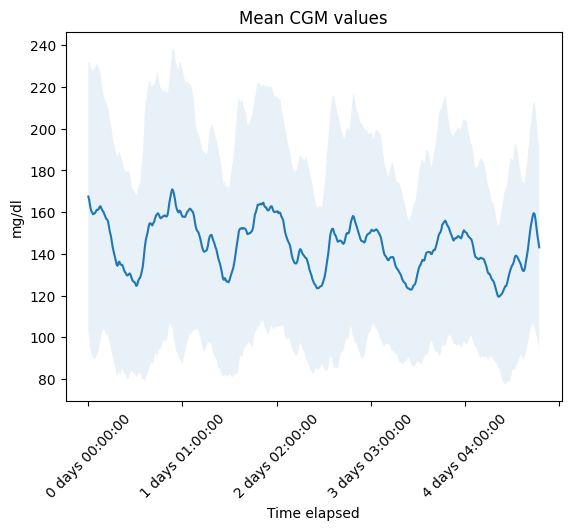

In [114]:
plt.figure()
plt.title("Mean CGM values")
plt.ylabel("mg/dl")
plt.xlabel("Time elapsed")
df.mean().plot()
plt.fill_between(df.columns, df.mean()+std , df.mean() - std, alpha =0.1)
plt.xticks(rotation=45)
plt.show()

The mean CGM waveform is not too useful for most applications, as you can see the +-1 standard deviation spans almost the entire physiological range. However, it does still retain a periodicity which is useful for choosing a p in our arima model.

[]

<Figure size 640x480 with 0 Axes>

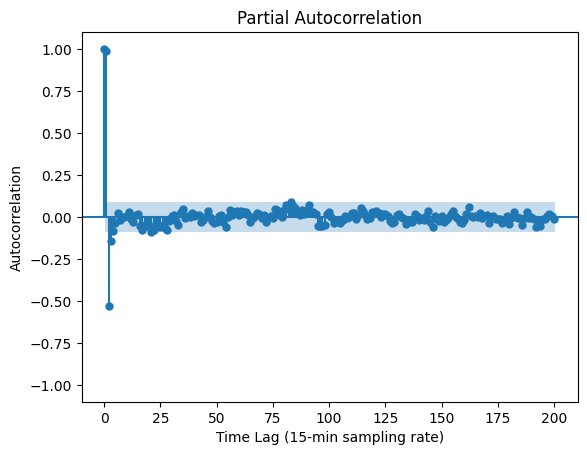

In [127]:
plt.figure()
plot_pacf(mean_df, lags=200)
plt.ylabel("Autocorrelation")
plt.ylim(-1.1,1.1)
plt.xlabel("Time Lag (15-min sampling rate)")
plt.plot()

The partial autocorrelation plot shows us the autocorrelation between each time-lagged version of the time-series, ignoring correlation that is already accounted for in the previous time-lags. This diagram shows after 3 time points the autocorrelation is mostly accounted for. Therefore we will use <b> p=3 </b>

## Finding D

We choose a d value in order to make our timeseries stationary: meaning the rolling mean does not change significantly over time.
Visually the mean cgm data appears stationary, we can confirm this with the Dickey_Fuller test.
We will repeat the test with a some individual patient data to confirm the individual waveforms are stationary as well.

In [97]:
print("mean_cgm p-value:",adfuller(mean_df)[1])
print("ptid 0 p-value:",adfuller(train_df.iloc[0,:])[1])
print("ptid 1 p-value:",adfuller(train_df.iloc[1,:])[1])

mean_cgm p-value: 0.0017661590226097418
ptid 0 p-value: 7.049700374905555e-06
ptid 1 p-value: 1.5338793297652423e-05


The p-value for each below 0.05 meaning we reject the null hypothesis. We can consider the time series as stationary. Therefore,  we can use <b>d=0 </b>.

## Finding q

We can use an autocorrelation plot to determine the optimal q value.

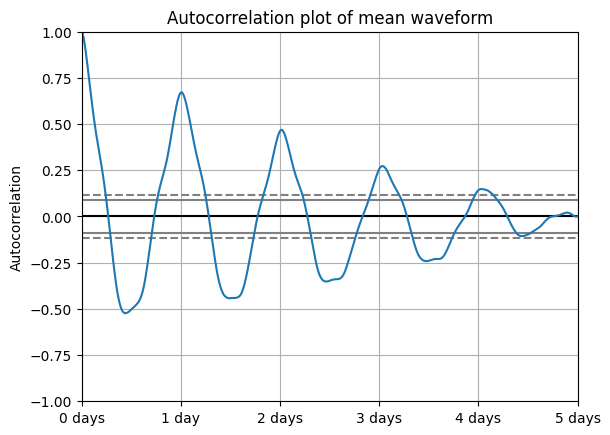

In [102]:
fig = plt.figure()
ax = plt.gca()
plt.title("Autocorrelation plot of mean waveform")
autocorrelation_plot(mean_df)
a=ax.get_xticks().tolist()
a = ["0 days", "1 day", "2 days", "3 days", "4 days", "5 days"]
plt.xticks([96*0,96*1,96*2,96*3,96*4,96*5], labels = a)
plt.xlabel("")
plt.show()


This autocorrelation plot shows a decaying sinusoidal autocorrelation, with a period of 1 day. This make sense since physiologically we can expect time of day to be correlated with glucose readings. Since there is no clear cut off value to use for q, we will set it to 0.

# Building and Testing Arima Model

Our chosen (p,d,q) values are (3,0,0). This aligns with the findings from <i>Real-Time Statistical Modeling of Blood Sugar</i> by Otoom et al. We will now build the ARIMA model and test its performance

Predicting just 1 timestep in the future

In [52]:
total_length = train_df.shape[1]
train_length = 5
predict_length = total_length - train_length
patient = 0
pred_list = []
steps = 1


pred = [] 
for i in range(predict_length):
    model = ARIMA(train_df.iloc[patient,:train_length+i].values, order=(3,0,0))
    model_fit = model.fit()
    pred.append(model_fit.forecast(steps=steps)[-1])
pred_list.append(pred)

C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


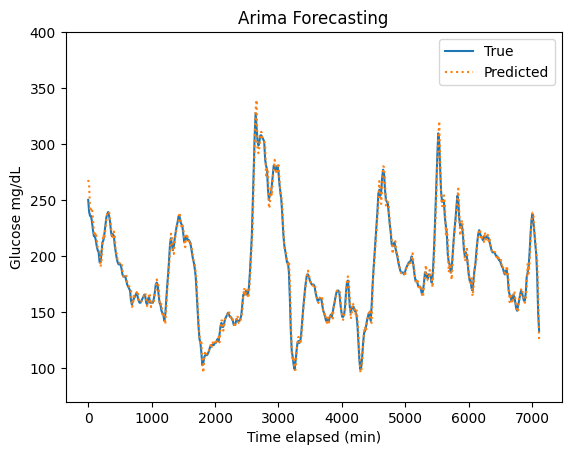

In [55]:
true = train_df.iloc[patient,train_length:train_length+predict_length]
x = [x*15 for x in range(len(true))]
plt.figure()
plt.plot(x,true, label="True")
plt.plot(x,pred, ":", label = "Predicted")
plt.legend()
plt.ylim([70,400])
plt.ylabel("Glucose mg/dL")
plt.xlabel("Time elapsed (min)")
plt.title("Arima Forecasting")
plt.show()


Predicting 3 timesteps

In [77]:
total_length = train_df.shape[1]
train_length = 5
predict_length = total_length - train_length
num_patients = 30
predicted_list = []
steps = 3

for patient in tqdm(range(num_patients)):
    pred = [] 
    for i in range(predict_length):
        model = ARIMA(train_df.iloc[patient,:train_length+i].values, order=(3,0,0))
        model_fit = model.fit()
        pred.append(model_fit.forecast(steps=steps)[-1])
    predicted_list.append(pred)
    

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|██▊                                                                                | 1/30 [00:44<21:43, 44.96s/it]C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|█████▌                                                 

 63%|███████████████████████████████████████████████████▉                              | 19/30 [12:44<07:00, 38.24s/it]C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 67%|██████████████████████████████████████████████████████▋                           | 20/30 [13:30<06:44, 40.46s/it]C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 70%|███████████████████████████████████████████████████████

In [80]:
predicted_list = torch.from_numpy(np.array(predicted_list))
true = torch.from_numpy(train_df.iloc[0:num_patients,train_length:].values)
mean_abs_percentage_error = MeanAbsolutePercentageError()
mean_abs_percentage_error(true,predicted_list)

tensor(0.0604)

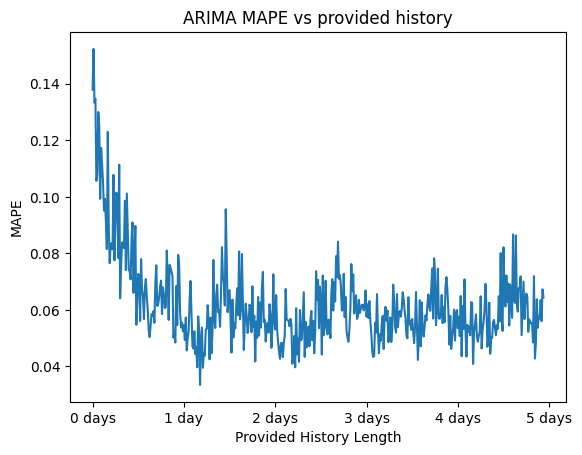

In [88]:
plt.figure()
plt.plot(abs((true-predicted_list)/true).mean(axis=0))
plt.title("ARIMA MAPE vs provided history")
plt.xlabel("Provided History Length")
plt.ylabel("MAPE")
plt.xticks([96*0,96*1,96*2,96*3,96*4, 96*5],labels=["0 days","1 day", "2 days", '3 days' , '4 days', '5 days'])
plt.show()

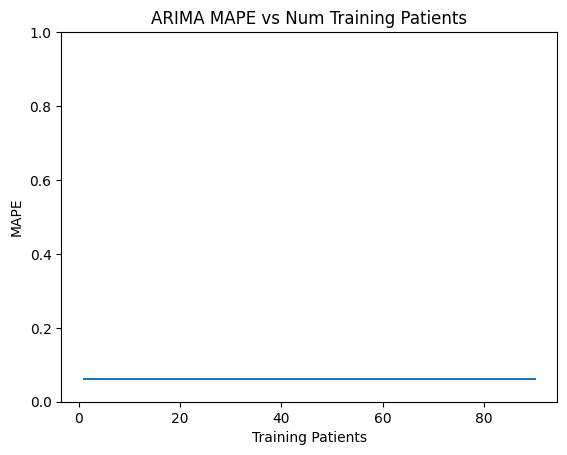

In [82]:
x  = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90]
y = [0.0604 for y in x]
plt.figure()
plt.plot(x,y)
plt.title("ARIMA MAPE vs Num Training Patients")
plt.xlabel("Training Patients")
plt.ylabel("MAPE")
plt.ylim([0,1])
plt.show()

### MAPE VS Prediction Horizon

In [67]:
total_length = train_df.shape[1]
train_length = 5
predict_length = total_length - train_length
patient = 1
pred_list = []
prediction_horizons = range(1,9)

for steps in tqdm(prediction_horizons):
    pred = [] 
    for i in range(predict_length):
        model = ARIMA(train_df.iloc[patient,:train_length+i].values, order=(3,0,0))
        model_fit = model.fit()
        pred.append(model_fit.forecast(steps=steps)[-1])
    pred_list.append(pred)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|██████████▌                                                                         | 1/8 [00:35<04:06, 35.17s/it]C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\statsmod

In [72]:
true = torch.from_numpy(train_df.iloc[patient,train_length:].values)
error_list = []
for i, pred in enumerate(pred_list):
    mean_abs_percentage_error = MeanAbsolutePercentageError()
    error_list.append(mean_abs_percentage_error(true,torch.Tensor(pred)))


In [73]:
error_list

[tensor(0.0438),
 tensor(0.0560),
 tensor(0.0768),
 tensor(0.0989),
 tensor(0.1180),
 tensor(0.1340),
 tensor(0.1478),
 tensor(0.1598)]

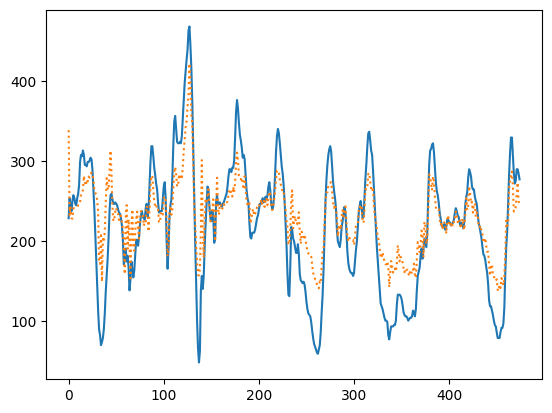

In [74]:
plt.plot(true)
plt.plot(pred,":")

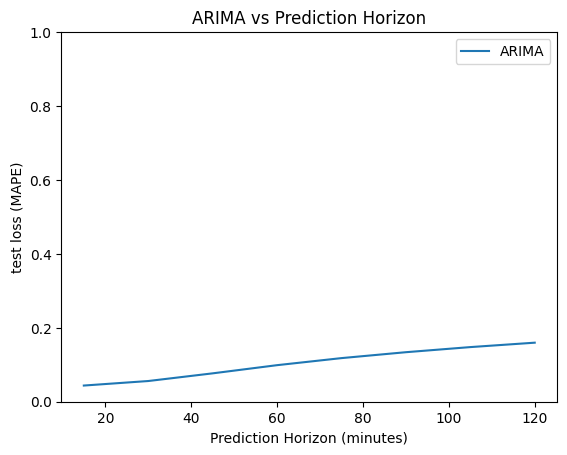

In [76]:
#Training Curve
plt.figure()
plt.plot([15*x for x in prediction_horizons],error_list, label = "ARIMA")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Prediction Horizon (minutes)")
plt.title("ARIMA vs Prediction Horizon")
plt.ylim(0,1)
plt.legend()
plt.show()